# **Importing Libraries**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud

# **Preparing Datasets**

In [ ]:
# Load the datasets
file_paths = {
    "parsed_dataset": "/content/drive/MyDrive/Sentiment Analysis/twitter_parsed_dataset.csv",
    "racism_dataset": "/content/drive/MyDrive/Sentiment Analysis/twitter_racism_parsed_dataset.csv",
    "sexism_dataset": "/content/drive/MyDrive/Sentiment Analysis/twitter_sexism_parsed_dataset.csv"
}

# Load the CSV files into dataframes
parsed_dataset = pd.read_csv(file_paths["parsed_dataset"])
racism_dataset = pd.read_csv(file_paths["racism_dataset"])
sexism_dataset = pd.read_csv(file_paths["sexism_dataset"])

# Display basic information about each dataset
parsed_info = parsed_dataset.info()
racism_info = racism_dataset.info()
sexism_info = sexism_dataset.info()

# Display the first few rows to understand their structure
parsed_head = parsed_dataset.head()
racism_head = racism_dataset.head()
sexism_head = sexism_dataset.head()

parsed_info, parsed_head, racism_info, racism_head, sexism_info, sexism_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16851 entries, 0 to 16850
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       16851 non-null  object 
 1   id          16850 non-null  object 
 2   Text        16850 non-null  object 
 3   Annotation  16848 non-null  object 
 4   oh_label    16848 non-null  float64
dtypes: float64(1), object(4)
memory usage: 658.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       13471 non-null  float64
 1   id          13471 non-null  float64
 2   Text        13471 non-null  object 
 3   Annotation  13471 non-null  object 
 4   oh_label    13471 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 526.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14881 entries, 0 to 14880
Data columns (to

(None,
                    index                     id  \
 0  5.74948705591165E+017  5.74948705591165E+017   
 1  5.71917888690393E+017  5.71917888690393E+017   
 2  3.90255841338601E+017  3.90255841338601E+017   
 3  5.68208850655916E+017  5.68208850655916E+017   
 4  5.75596338802373E+017  5.75596338802373E+017   
 
                                                 Text Annotation  oh_label  
 0  @halalflaws @biebervalue @greenlinerzjm I read...       none       0.0  
 1  @ShreyaBafna3 Now you idiots claim that people...       none       0.0  
 2  RT @Mooseoftorment Call me sexist, but when I ...     sexism       1.0  
 3  @g0ssipsquirrelx Wrong, ISIS follows the examp...     racism       1.0  
 4                             #mkr No No No No No No       none       0.0  ,
 None,
           index            id  \
 0  5.767493e+17  5.767493e+17   
 1  5.408905e+17  5.408905e+17   
 2  5.678433e+17  5.678433e+17   
 3  5.766462e+17  5.766462e+17   
 4  5.713492e+17  5.713492e+17   
 
   

In [ ]:
# Remove any missing values for a cleaner split
parsed_dataset.dropna(subset=['Text', 'oh_label'], inplace=True)

# Define features and labels
X = parsed_dataset['Text']  # Features: the tweet texts
y = parsed_dataset['oh_label']  # Labels: sentiment categories

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Show the sizes of each subset to confirm the split
print(len(X_train), len(X_val), len(X_test))

11793 2527 2528


In [ ]:
# Count the number of instances for each label in the parsed dataset
label_counts = parsed_dataset['oh_label'].value_counts()

# Display the counts for each label
print("Label distribution in the dataset:")
print(label_counts)

Label distribution in the dataset:
oh_label
0.0    11501
1.0     5347
Name: count, dtype: int64


# **Data Pre-processing**

In [ ]:
# Function to remove URLs from the text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Apply the function to the 'Text' column to clean up the tweets
parsed_dataset['Cleaned_Text'] = parsed_dataset['Text'].apply(remove_urls)

# Display the first few cleaned tweets to verify
print(parsed_dataset[['Text', 'Cleaned_Text']].head())


                                                Text  \
0  @halalflaws @biebervalue @greenlinerzjm I read...   
1  @ShreyaBafna3 Now you idiots claim that people...   
2  RT @Mooseoftorment Call me sexist, but when I ...   
3  @g0ssipsquirrelx Wrong, ISIS follows the examp...   
4                             #mkr No No No No No No   

                                        Cleaned_Text  
0  @halalflaws @biebervalue @greenlinerzjm I read...  
1  @ShreyaBafna3 Now you idiots claim that people...  
2  RT @Mooseoftorment Call me sexist, but when I ...  
3  @g0ssipsquirrelx Wrong, ISIS follows the examp...  
4                             #mkr No No No No No No  


In [ ]:
# Ensure you have the required NLTK resources
nltk.download('punkt')

# Define a function to tokenize text using NLTK
def tokenize_text_nltk(text):
    tokens = word_tokenize(text)
    return tokens

# Apply the tokenization function to the 'Cleaned_Text' column
parsed_dataset['Tokenized_Text'] = parsed_dataset['Cleaned_Text'].apply(tokenize_text_nltk)

# Display the first few tokenized texts to verify
print(parsed_dataset[['Cleaned_Text', 'Tokenized_Text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                        Cleaned_Text  \
0  @halalflaws @biebervalue @greenlinerzjm I read...   
1  @ShreyaBafna3 Now you idiots claim that people...   
2  RT @Mooseoftorment Call me sexist, but when I ...   
3  @g0ssipsquirrelx Wrong, ISIS follows the examp...   
4                             #mkr No No No No No No   

                                      Tokenized_Text  
0  [@, halalflaws, @, biebervalue, @, greenlinerz...  
1  [@, ShreyaBafna3, Now, you, idiots, claim, tha...  
2  [RT, @, Mooseoftorment, Call, me, sexist, ,, b...  
3  [@, g0ssipsquirrelx, Wrong, ,, ISIS, follows, ...  
4                   [#, mkr, No, No, No, No, No, No]  


In [ ]:
negation_words = ["not", "never", "no", "n't", "none", "nothing", "nowhere", "neither", "nor", "noone"]

In [ ]:
def detect_negations(tokens, negation_words):
    negation_positions = []
    negation_found = False

    for i, token in enumerate(tokens):
        if token.lower() in negation_words:
            negation_positions.append(i)
            negation_found = True

    return negation_positions, negation_found

In [ ]:
parsed_dataset['Negation_Positions'], parsed_dataset['Negation_Found'] = zip(*parsed_dataset['Tokenized_Text'].apply(lambda tokens: detect_negations(tokens, negation_words)))

# Display the first few rows to verify
print(parsed_dataset[['Tokenized_Text', 'Negation_Positions', 'Negation_Found']].head())

                                      Tokenized_Text  Negation_Positions  \
0  [@, halalflaws, @, biebervalue, @, greenlinerz...                  []   
1  [@, ShreyaBafna3, Now, you, idiots, claim, tha...                  []   
2  [RT, @, Mooseoftorment, Call, me, sexist, ,, b...                  []   
3  [@, g0ssipsquirrelx, Wrong, ,, ISIS, follows, ...                  []   
4                   [#, mkr, No, No, No, No, No, No]  [2, 3, 4, 5, 6, 7]   

   Negation_Found  
0           False  
1           False  
2           False  
3           False  
4            True  


In [ ]:
def calculate_coverage(negation_found_series):
    total_tweets = len(negation_found_series)
    negation_tweets = negation_found_series.sum()  # Count of True values
    coverage = negation_tweets / total_tweets
    return coverage

coverage = calculate_coverage(parsed_dataset['Negation_Found'])
print(f"Negation Coverage: {coverage:.2%}")

Negation Coverage: 31.23%


# **Feature Extraction**

In [ ]:
# Initialize the vectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the validation and test data
X_val_vectorized = vectorizer.transform(X_val)
X_test_vectorized = vectorizer.transform(X_test)

In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation and test data
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# **Model Training**

**Logistic Regression**

In [ ]:
# Initialize and train the model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predict on validation and test data
y_val_pred = model.predict(X_val_tfidf)
y_test_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      1725
         1.0       0.82      0.62      0.71       802

    accuracy                           0.84      2527
   macro avg       0.83      0.78      0.80      2527
weighted avg       0.84      0.84      0.83      2527

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88      1726
         1.0       0.81      0.56      0.66       802

    accuracy                           0.82      2528
   macro avg       0.82      0.75      0.77      2528
weighted avg       0.82      0.82      0.81      2528



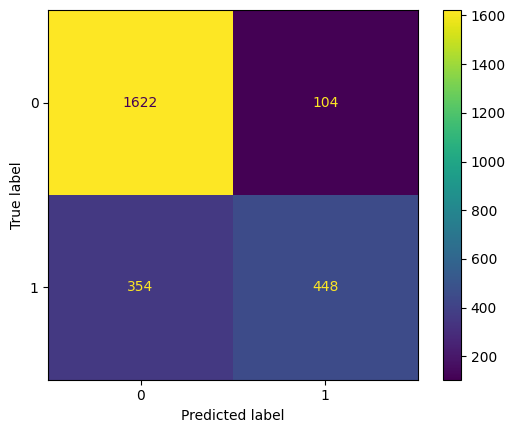

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**Random Forest**

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Predict on validation and test data
y_val_pred_rf = rf_model.predict(X_val_tfidf)
y_test_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate the model
print("Validation Classification Report for Random Forest:")
print(classification_report(y_val, y_val_pred_rf))

print("Test Classification Report for Random Forest:")
print(classification_report(y_test, y_test_pred_rf))

# Print accuracy scores
print(f"Validation Accuracy for Random Forest: {accuracy_score(y_val, y_val_pred_rf):.2f}")
print(f"Test Accuracy for Random Forest: {accuracy_score(y_test, y_test_pred_rf):.2f}")

Validation Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89      1725
         1.0       0.87      0.58      0.70       802

    accuracy                           0.84      2527
   macro avg       0.85      0.77      0.79      2527
weighted avg       0.85      0.84      0.83      2527

Test Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.89      1726
         1.0       0.87      0.55      0.67       802

    accuracy                           0.83      2528
   macro avg       0.84      0.75      0.78      2528
weighted avg       0.84      0.83      0.82      2528

Validation Accuracy for Random Forest: 0.84
Test Accuracy for Random Forest: 0.83


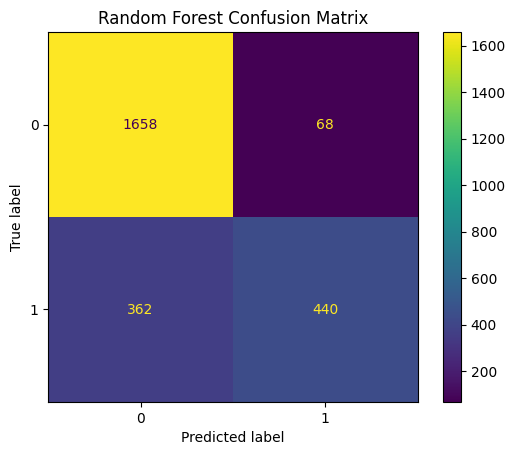

In [ ]:
# Generate confusion matrix for Random Forest on test data
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

# Display confusion matrix for Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

**SVM**

In [ ]:
# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Train the model
svm_model.fit(X_train_tfidf, y_train)

# Predict on validation and test data
y_val_pred_svm = svm_model.predict(X_val_tfidf)
y_test_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate the model
print("Validation Classification Report for SVM:")
print(classification_report(y_val, y_val_pred_svm))

print("Test Classification Report for SVM:")
print(classification_report(y_test, y_test_pred_svm))

# Print accuracy scores
print(f"Validation Accuracy for SVM: {accuracy_score(y_val, y_val_pred_svm):.2f}")
print(f"Test Accuracy for SVM: {accuracy_score(y_test, y_test_pred_svm):.2f}")

Validation Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90      1725
         1.0       0.81      0.71      0.76       802

    accuracy                           0.86      2527
   macro avg       0.84      0.82      0.83      2527
weighted avg       0.85      0.86      0.85      2527

Test Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89      1726
         1.0       0.81      0.66      0.73       802

    accuracy                           0.84      2528
   macro avg       0.83      0.79      0.81      2528
weighted avg       0.84      0.84      0.84      2528

Validation Accuracy for SVM: 0.86
Test Accuracy for SVM: 0.84


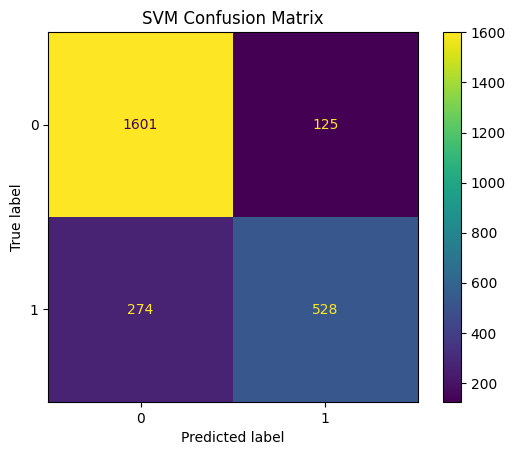

In [ ]:
# Generate confusion matrix for SVM on test data
cm_svm = confusion_matrix(y_test, y_test_pred_svm)

# Display confusion matrix for SVM
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()
plt.title('SVM Confusion Matrix')
plt.show()

In [ ]:
pip install wordcloud

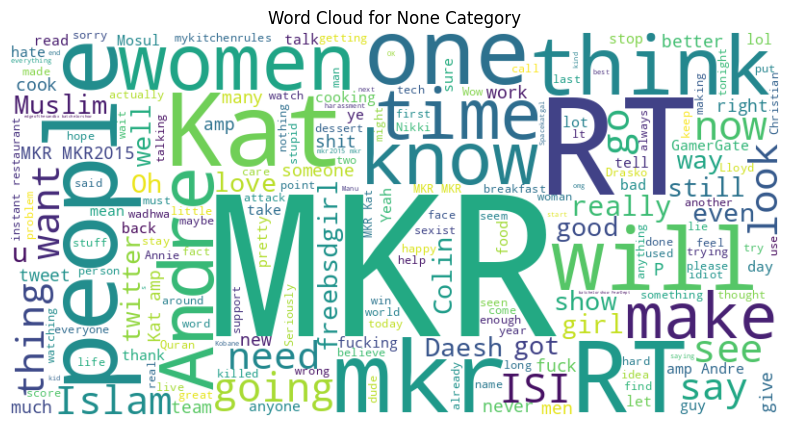

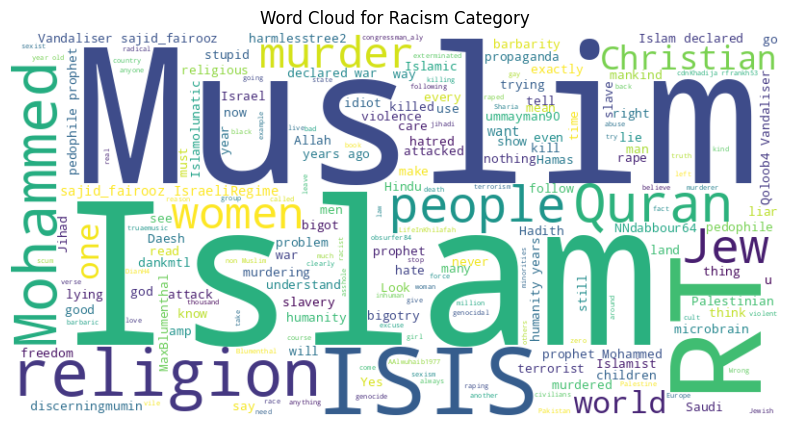

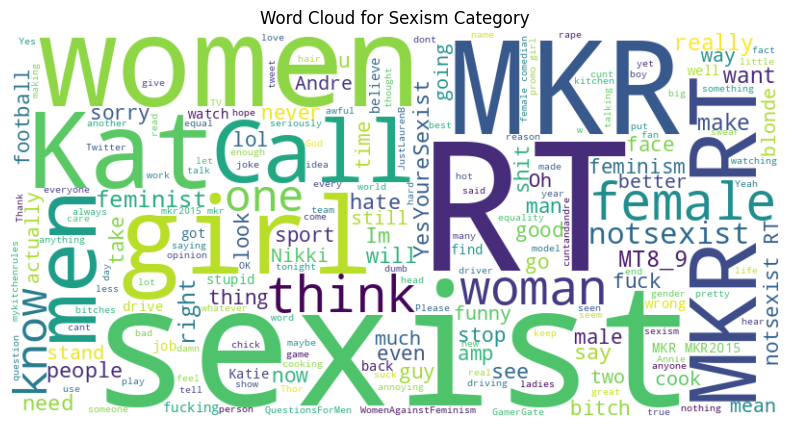

In [ ]:
# Function to generate and plot word clouds
def generate_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Separate the dataset by the 'Annotation' column into none, racism, and sexism
none_tweets = parsed_dataset[parsed_dataset['Annotation'] == 'none']['Cleaned_Text']
racism_tweets = parsed_dataset[parsed_dataset['Annotation'] == 'racism']['Cleaned_Text']
sexism_tweets = parsed_dataset[parsed_dataset['Annotation'] == 'sexism']['Cleaned_Text']

# Generate and display word clouds for each category
generate_wordcloud(none_tweets, 'Word Cloud for None Category')
generate_wordcloud(racism_tweets, 'Word Cloud for Racism Category')
generate_wordcloud(sexism_tweets, 'Word Cloud for Sexism Category')

In [ ]:
# Filter the dataset for tweets mentioning @YesYoureSexist and annotated as sexism
sexism_tweets_with_mention = parsed_dataset[
    (parsed_dataset['Annotation'] == 'sexism') &
    (parsed_dataset['Text'].str.contains('@YesYoureSexist', case=False, na=False))
]

# Display the top 10 tweets
top_10_sexism_tweets = sexism_tweets_with_mention.head(10)

# Print the relevant columns for better readability
print(top_10_sexism_tweets[['Text', 'Annotation']])


                                                                                                                                              Text  \
138                                                                            RT @GrumpyVancouver: @YesYoureSexist maybe so. But I'm still right.   
165   RT @RyanGebble: @YesYoureSexist Because FemShep was a character created to appease people in a pathetic way and didn't add depth or any dif…   
402   RT @oldgfatherclock: @YesYoureSexist @mjb_1971 it's not the same job...otherwise they'd be competing against each other. Better sportsperso…   
730   RT @jimboslice_13: @YesYoureSexist you insinuated twitter raping me yesterday. Also saying only women get raped, that is sexist. Little bes…   
826                                                               RT @Deanowen118: @YesYoureSexist @PhilDoran21 typical woman sticking her nose in   
889   RT @IMrTrippy: @IronCurtaiNYC @YesYoureSexist I'm all for equal rights, just annoying that the